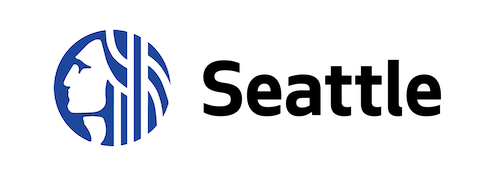


<h1><center> NOTEBOOK EMISSIONS CO2
   

Objectif : vous voulez tenter de prédire les émissions de CO2 de bâtiments non destinés à l’habitation.

# Sommaire <a id="0"></a>



I.  [Importation des librairies et données](#1)<br>

II.  [Préparation du jeu de données](#2)<br>

III.  [Regression linéaire simple](#3) <br>

IV. [Ridge regression ](#4)<br>

V. [Lasso  ](#5)<br>

VI. [Kernel regression](#6)<br>

VII. [Arbre de décision](#7)<br>

VIII. [Gradient boosting regression](#8)<br>



IX. [Intérêt Energy Star Score](#9) <br>



# Import files and librairies <a id="1"></a>

In [1]:
#import necessary libraries for scientific computation and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import libraries for regression & metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#import libraries for preprocessing and feature engineering
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.compose import TransformedTargetRegressor
#import libraries for cross validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge # Kernel regression
#librairies for decision trees
from sklearn import tree 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance #model inspection


# II. Préparation du jeu données <a id="2"></a>

In [2]:
#import file
benchmark_NR=pd.read_csv("benchmark_NR.csv")

In [3]:
benchmark_NR.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SteamUse(%),Electricity(%),NaturalGas(%),Age
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,60.0,7456910.0,2003882.00,3946027.0,1276453.0,249.98,27.730162,54.605993,17.663838,89
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,61.0,8664479.0,0.00,3242851.0,5145082.0,295.86,0.000000,38.660907,61.339093,20
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,43.0,73937112.0,21566554.00,49526664.0,1493800.0,2089.28,29.711308,68.230741,2.057944,47
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,56.0,6946800.5,2214446.25,2768924.0,1811213.0,286.43,32.591344,40.751928,26.656717,90
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,75.0,14656503.0,0.00,5368607.0,8803998.0,505.01,0.000000,37.880168,62.119825,36


In [4]:
benchmark_NR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664 entries, 0 to 1663
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1664 non-null   int64  
 1   DataYear                         1664 non-null   int64  
 2   BuildingType                     1664 non-null   object 
 3   PrimaryPropertyType              1664 non-null   object 
 4   PropertyName                     1664 non-null   object 
 5   Address                          1664 non-null   object 
 6   City                             1664 non-null   object 
 7   State                            1664 non-null   object 
 8   ZipCode                          1648 non-null   float64
 9   TaxParcelIdentificationNumber    1664 non-null   object 
 10  CouncilDistrictCode              1664 non-null   int64  
 11  Neighborhood                     1664 non-null   object 
 12  Latitude            

**transformation des variables**

Nous utilisons la fonction log(1 + x) pour transformer les colonnes indiquant la surface dont la distribution était étallée à droite.
Nous allons aussi transformer la cible avec la même fonction.

In [5]:
for col in ['PropertyGFATotal',
            'PropertyGFABuilding(s)',
            'PropertyGFAParking',
            'LargestPropertyUseTypeGFA',
            'SecondLargestPropertyUseTypeGFA',
            'ThirdLargestPropertyUseTypeGFA',
            ]:
    benchmark_NR[col+'_tr']=np.log1p(benchmark_NR[col])

In [6]:
#sélection des colonnes
col_x=['Neighborhood',
    'NumberofBuildings',
    'NumberofFloors', 
    'LargestPropertyUseType', 
    'SteamUse(%)', 
    'Electricity(%)', 
    'NaturalGas(%)', 
    'Age',
    'PropertyGFATotal_tr', 
    'PropertyGFABuilding(s)_tr', 
    'PropertyGFAParking_tr', 
    'LargestPropertyUseTypeGFA_tr'
      ]
X_CO2=benchmark_NR.loc[:,col_x]
y_CO2=benchmark_NR.loc[:,'TotalGHGEmissions']

**train_test split**

In [7]:
X_CO2_train,X_CO2_test,y_CO2_train,y_CO2_test=train_test_split(X_CO2,y_CO2, test_size=0.25, random_state=2022)
X_CO2_train.shape

(1248, 12)

**Normalisation des variables numériques & encodage des variables catégorielles**

Nous allons utiliser OneHotEncoder pour transformer les variables catégorielles en dummy variable et procéder au centrage et à la réduction des données numériques

In [8]:
ct = make_column_transformer(
    (preprocessing.StandardScaler(),
     make_column_selector(dtype_include=np.number)),  # colonnes numériques
    (OneHotEncoder(handle_unknown='ignore'),
     make_column_selector(dtype_include=object)))  # colonnes catégorie

X_CO2_train_tr=ct.fit_transform(X_CO2_train) 
X_CO2_test_tr=ct.transform(X_CO2_test)

Afin d'améliorer la lisibilité récupérons les noms des features et simplifions les noms

In [9]:
# récupérons les noms des features
features=pd.Series(ct.get_feature_names_out()).str.replace('PropertyUseType', 'PTU').str.split('__', expand=True).loc[:,1]

[Retour au sommaire](#0)<br>

# III. Regression simple <a id="3"></a>

## **Définition du modèle**

On définit un modèle de régression avec transformation de la cible `y` en log :

In [10]:
regressor = TransformedTargetRegressor(regressor=linear_model.LinearRegression(), func=np.log1p, inverse_func=np.expm1)

In [11]:
%%time
regressor.fit(X_CO2_train_tr, y_CO2_train)

Wall time: 9.97 ms


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LinearRegression())

calculons un score moyen par cross validation afin de comparer

In [12]:
lr_cv = cross_validate(regressor,X_CO2_train_tr, y_CO2_train, cv=5,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
                       return_train_score=True,
                       return_estimator=True)

In [13]:
lr_cv

{'fit_time': array([0.00993609, 0.00797772, 0.00897813, 0.00793815, 0.00797796]),
 'score_time': array([0.00099373, 0.00099754, 0.00099373, 0.00099754, 0.00105262]),
 'estimator': [TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                             regressor=LinearRegression()),
  TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                             regressor=LinearRegression()),
  TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                             regressor=LinearRegression()),
  TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                             regressor=LinearRegression()),
  TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                             regressor=LinearRegression())],
 'test_r2': array([ 6.07565501e-01,  1.76598644e-01, -8.47408071e+04,  6.61660100e-01,
         8.68710043e-01]),
 

la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est :

In [14]:
np.mean(lr_cv['test_r2'])

-16947.69850770322

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [15]:
y_CO2_pred_test=regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [16]:
emmissions_moy_train=np.mean(y_CO2_train)
emmissions_moy_test=np.mean(y_CO2_test)

In [17]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/émission moyenne: %.2f" % (np.sqrt(error_train)/emmissions_moy_train))
print("MAE entrainement/émission moyenne: %.2f" % (mae_train/emmissions_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/émission moyenne: %.2f" % (np.sqrt( error_test)/emmissions_moy_test))
print("MAE test/émission moyenne: %.2f" % (mae_test/emmissions_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/émission moyenne: 2.77
MAE entrainement/émission moyenne: 0.45
Coefficient de determination entrainement: 0.55 

RMSE test/émission moyenne: 1.57
MAE test/émission moyenne: 0.37
Coefficient de determination test: 0.84


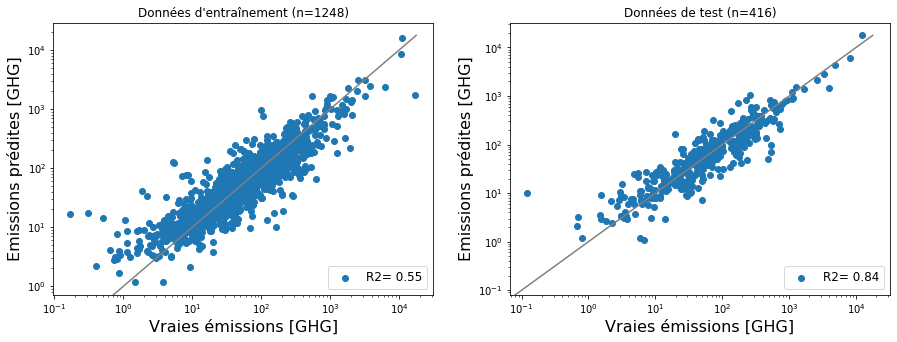

In [18]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vraies émissions [GHG]', fontsize=16)
    ax.set_ylabel(u'Emissions prédites [GHG]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

## Analyse des variables qui influe le plus sur la regression

In [19]:
coeff=pd.DataFrame(regressor.regressor_.coef_, features, columns=['Coefficients']).sort_values('Coefficients', ascending=False)

<AxesSubplot:xlabel='Coefficients', ylabel='1'>

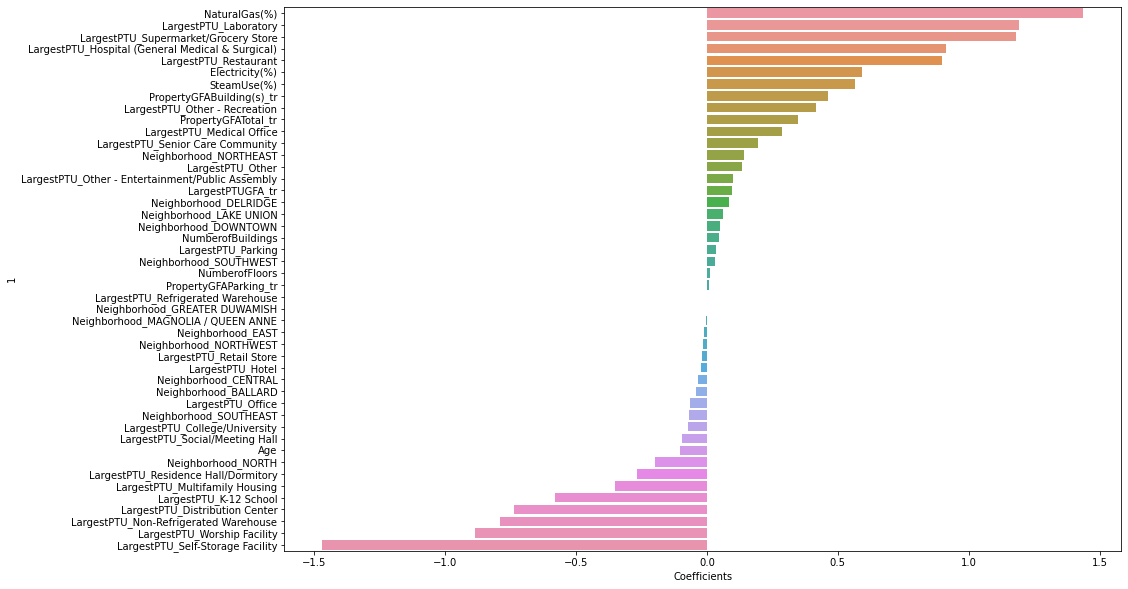

In [20]:
fig, ax1 =plt.subplots(figsize=(15,10))
sns.barplot(data=coeff, y=coeff.index,x='Coefficients')

[Retour au sommaire](#0)<br>

# IV. Ridge Regression <a id="4"></a>

## **Définition du modèle**

On définit un modèle de régression Ridge, avec transformation de la cible `y` en log :

In [21]:
regressor = TransformedTargetRegressor(regressor=linear_model.Ridge(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [22]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__copy_X', 'regressor__fit_intercept', 'regressor__max_iter', 'regressor__normalize', 'regressor__positive', 'regressor__random_state', 'regressor__solver', 'regressor__tol', 'regressor', 'transformer'])

In [23]:
# set different regularisation strengths
n_alphas = 300
alphas = np.logspace(-5, 5, n_alphas)

param_grid = {
    'regressor__alpha': alphas   
}

In [24]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    param_grid=param_grid, 
    cv=5, 
    verbose=True,
    refit='r2'
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Wall time: 6.06 s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Ridge()),
             param_grid={'regressor__alpha': array([1.00000000e-05, 1.08005237e-05, 1.16651313e-05, 1.25989528e-05,
       1.36075289e-05, 1.46968439e-05, 1.58733611e-05, 1.71440614e-05,
       1.85164842e-05, 1.99987727e-05, 2.15997219e-05, 2.33288310e-05,
       2.51963593...
       2.31498667e+04, 2.50030685e+04, 2.70046235e+04, 2.91664078e+04,
       3.15012480e+04, 3.40229977e+04, 3.67466194e+04, 3.96882735e+04,
       4.28654141e+04, 4.62968923e+04, 5.00030684e+04, 5.40059328e+04,
       5.83292359e+04, 6.29986298e+04, 6.80418197e+04, 7.34887289e+04,
       7.93716762e+04, 8.57255673e+04, 9.25881025e+04, 1.00000000e+05])},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_er

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [25]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,212,211,213,210,214,215,209,216,217,208,...,17,29,1,8,18,37,45,44,47,19
mean_fit_time,0.006248,0.003124,0.003124,0.003124,0.003124,0.003124,0.003126,0.003124,0.003124,0.002754,...,0.002731,0.003124,0.004196,0.004341,0.003124,0.006249,0.005006,0.005622,0.0,0.003125
std_fit_time,0.007653,0.006248,0.006249,0.006248,0.006248,0.006249,0.006251,0.006249,0.006249,0.002601,...,0.005463,0.006249,0.000755,0.005826,0.006249,0.007653,0.006284,0.00791,0.0,0.006251
mean_score_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000416,...,0.003131,0.0,0.000591,0.000903,0.0,0.0,0.0004,0.000422,0.003128,0.0
std_score_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00051,...,0.006262,0.0,0.000483,0.001376,0.0,0.0,0.000489,0.000518,0.006256,0.0
param_regressor__alpha,123.112175,113.987227,132.967597,105.53861,143.611969,155.108448,97.716197,167.525247,180.936041,90.473572,...,0.000037,0.000093,0.000011,0.000019,0.00004,0.000173,0.00032,0.000296,0.000373,0.000043
params,{'regressor__alpha': 123.11217482038896},{'regressor__alpha': 113.98722666160502},{'regressor__alpha': 132.96759674662098},{'regressor__alpha': 105.5386103036523},{'regressor__alpha': 143.61196859990773},{'regressor__alpha': 155.10844769528404},{'regressor__alpha': 97.71619672696161},{'regressor__alpha': 167.5252472408214},{'regressor__alpha': 180.93604107387165},{'regressor__alpha': 90.47357242349293},...,{'regressor__alpha': 3.703069584005141e-05},{'regressor__alpha': 9.33038717262036e-05},{'regressor__alpha': 1.080052374516254e-05},{'regressor__alpha': 1.851648417912154e-05},{'regressor__alpha': 3.999509097203661e-05},{'regressor__alpha': 0.00017276596646690346},{'regressor__alpha': 0.0003199018284775064},{'regressor__alpha': 0.0002961910329772553},{'regressor__alpha': 0.00037316968377327516},{'regressor__alpha': 4.319679297334174e-05}
split0_test_r2,0.314166,0.318989,0.309525,0.323436,0.304731,0.300297,0.32778,0.295076,0.289681,0.332038,...,0.594431,0.594416,0.594429,0.594424,0.594417,0.594433,0.594445,0.594424,0.594432,0.594422
split1_test_r2,0.133492,0.135837,0.130869,0.138166,0.128527,0.126144,0.140483,0.123716,0.121341,0.142789,...,0.18316,0.183179,0.178321,0.18317,0.183173,0.178613,0.183124,0.178342,0.178343,0.17836
split2_test_r2,0.691266,0.66738,0.70241,0.626638,0.703956,0.698302,0.563649,0.686247,0.671329,0.471353,...,-55149.510931,-55152.217976,-55152.944036,-55160.410498,-55161.096743,-55171.347286,-55232.598619,-55233.693177,-55285.075361,-55311.298779
split3_test_r2,0.577393,0.583106,0.571381,0.588986,0.565058,0.558412,0.594219,0.551431,0.544032,0.599199,...,0.663192,0.663197,0.663206,0.663203,0.663195,0.663201,0.663204,0.663203,0.663201,0.663191


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [26]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Ridge(alpha=123.11217482038896))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [27]:
best_regressor.regressor_.get_params()

{'alpha': 123.11217482038896,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [28]:
grid_search.best_score_

0.4817174638364773

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [29]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [30]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/émission moyenne: %.2f" % (np.sqrt(error_train)/emmissions_moy_train))
print("MAE entrainement/émission moyenne:: %.2f" % (mae_train/emmissions_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/émission moyenne:: %.2f" % (np.sqrt( error_test)/emmissions_moy_test))
print("MAE test/émission moyenne:: %.2f" % (mae_test/emmissions_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/émission moyenne: 3.18
MAE entrainement/émission moyenne:: 0.54
Coefficient de determination entrainement: 0.41 

RMSE test/émission moyenne:: 2.58
MAE test/émission moyenne:: 0.55
Coefficient de determination test: 0.56


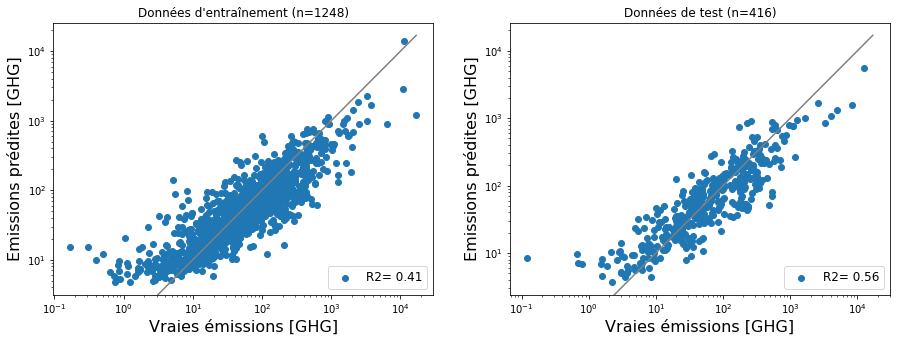

In [31]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vraies émissions [GHG]', fontsize=16)
    ax.set_ylabel(u'Emissions prédites [GHG]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

## Analyse des variables qui influent le plus sur la regression

In [32]:
coeff=pd.DataFrame(best_regressor.regressor_.coef_, features, columns=['Coefficients']).sort_values('Coefficients', ascending=False)

<AxesSubplot:xlabel='Coefficients', ylabel='1'>

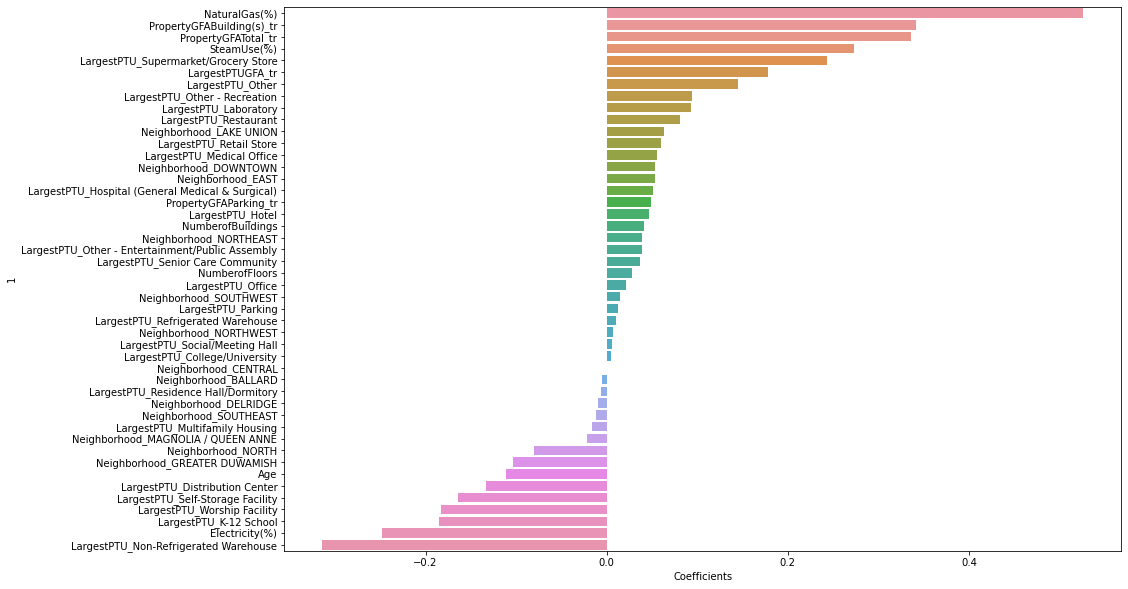

In [33]:
fig, ax1 =plt.subplots(figsize=(15,10))
sns.barplot(data=coeff, y=coeff.index,x='Coefficients')

[Retour au sommaire](#0)<br>

## V. Lasso Regression <a id="5"></a>

## **Définition du modèle**

On définit un modèle de régression Lasso, avec transformation de la cible `y` en log :

In [34]:
regressor = TransformedTargetRegressor(regressor=linear_model.Lasso(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [35]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__copy_X', 'regressor__fit_intercept', 'regressor__max_iter', 'regressor__normalize', 'regressor__positive', 'regressor__precompute', 'regressor__random_state', 'regressor__selection', 'regressor__tol', 'regressor__warm_start', 'regressor', 'transformer'])

In [36]:
# set different regularisation strengths
n_alphas = 300
alphas = np.logspace(-5, 5, n_alphas)

param_grid = {
    'regressor__alpha': alphas,
    'regressor__max_iter' :[10000]
}

In [37]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    param_grid=param_grid, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    cv=5, 
    verbose=True,
    refit='r2',
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Wall time: 34.3 s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Lasso()),
             param_grid={'regressor__alpha': array([1.00000000e-05, 1.08005237e-05, 1.16651313e-05, 1.25989528e-05,
       1.36075289e-05, 1.46968439e-05, 1.58733611e-05, 1.71440614e-05,
       1.85164842e-05, 1.99987727e-05, 2.15997219e-05, 2.33288310e-05,
       2.51963593...
       3.15012480e+04, 3.40229977e+04, 3.67466194e+04, 3.96882735e+04,
       4.28654141e+04, 4.62968923e+04, 5.00030684e+04, 5.40059328e+04,
       5.83292359e+04, 6.29986298e+04, 6.80418197e+04, 7.34887289e+04,
       7.93716762e+04, 8.57255673e+04, 9.25881025e+04, 1.00000000e+05]),
                         'regressor__max_iter': [10000]},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
       

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [38]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,83,82,84,85,81,86,87,88,89,90,...,9,8,7,6,5,4,3,2,1,0
mean_fit_time,0.024994,0.018745,0.018746,0.018745,0.025,0.021876,0.021864,0.021864,0.021761,0.018746,...,0.137574,0.150638,0.16241,0.17186,0.19067,0.240713,0.262667,0.234326,0.253136,0.291654
std_fit_time,0.007654,0.006248,0.006248,0.006247,0.007645,0.007647,0.007644,0.007646,0.007994,0.006253,...,0.037536,0.04064,0.040086,0.047399,0.049815,0.072275,0.08809,0.059272,0.065134,0.070806
mean_score_time,0.0,0.003124,0.003124,0.0,0.0,0.0,0.0,0.0,0.000208,0.0,...,0.0,0.002507,0.0,0.0,0.0,0.0,0.003123,0.0,0.003125,0.0
std_score_time,0.0,0.006249,0.006248,0.0,0.0,0.0,0.0,0.0,0.000416,0.0,...,0.0,0.005014,0.0,0.0,0.0,0.0,0.006245,0.0,0.006249,0.0
param_regressor__alpha,0.005969,0.005527,0.006447,0.006963,0.005117,0.007521,0.008123,0.008773,0.009475,0.010234,...,0.00002,0.000019,0.000017,0.000016,0.000015,0.000014,0.000013,0.000012,0.000011,0.00001
param_regressor__max_iter,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
params,"{'regressor__alpha': 0.005969249509970733, 're...","{'regressor__alpha': 0.005526814857144603, 're...","{'regressor__alpha': 0.006447102107323869, 're...","{'regressor__alpha': 0.006963207939763883, 're...","{'regressor__alpha': 0.005117173007114605, 're...","{'regressor__alpha': 0.007520629269592407, 're...","{'regressor__alpha': 0.008122673500479712, 're...","{'regressor__alpha': 0.008772912801613356, 're...","{'regressor__alpha': 0.009475205302806537, 're...","{'regressor__alpha': 0.010233717986325191, 're...",...,"{'regressor__alpha': 1.999877270535287e-05, 'r...","{'regressor__alpha': 1.851648417912154e-05, 'r...","{'regressor__alpha': 1.714406135851972e-05, 'r...","{'regressor__alpha': 1.5873361110102085e-05, '...","{'regressor__alpha': 1.4696843861124474e-05, '...","{'regressor__alpha': 1.3607528864243332e-05, '...","{'regressor__alpha': 1.2598952777950285e-05, '...","{'regressor__alpha': 1.1665131316981961e-05, '...","{'regressor__alpha': 1.080052374516254e-05, 'r...","{'regressor__alpha': 1e-05, 'regressor__max_it..."
split0_test_r2,0.414698,0.420506,0.408385,0.401564,0.425818,0.394199,0.386318,0.379425,0.374318,0.370889,...,0.606618,0.606689,0.606754,0.606814,0.60687,0.606922,0.606969,0.607013,0.607054,0.607092
split1_test_r2,0.198244,0.198777,0.197654,0.197,0.19925,0.196201,0.195283,0.194293,0.19316,0.191958,...,0.177171,0.177129,0.17709,0.177054,0.17702,0.17699,0.176961,0.176934,0.176909,0.176887
split2_test_r2,0.766389,0.750372,0.690637,0.584421,0.529578,0.530395,0.529863,0.529283,0.528558,0.525551,...,-80227.363996,-80551.953345,-80854.653795,-81136.182179,-81397.432022,-81639.98088,-81866.502892,-82075.754226,-82270.373923,-82450.874832


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [39]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Lasso(alpha=0.005969249509970733,
                                           max_iter=10000))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [40]:
best_regressor.regressor_.get_params()

{'alpha': 0.005969249509970733,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 10000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [41]:
grid_search.best_score_

0.5786387140126408

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [42]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [43]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/émission moyenne: %.2f" % (np.sqrt(error_train)/emmissions_moy_train))
print("MAE entrainement/émission moyenne:: %.2f" % (mae_train/emmissions_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/émission moyenne:: %.2f" % (np.sqrt( error_test)/emmissions_moy_test))
print("MAE test/émission moyenne:: %.2f" % (mae_test/emmissions_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/émission moyenne: 2.98
MAE entrainement/émission moyenne:: 0.49
Coefficient de determination entrainement: 0.48 

RMSE test/émission moyenne:: 2.16
MAE test/émission moyenne:: 0.48
Coefficient de determination test: 0.69


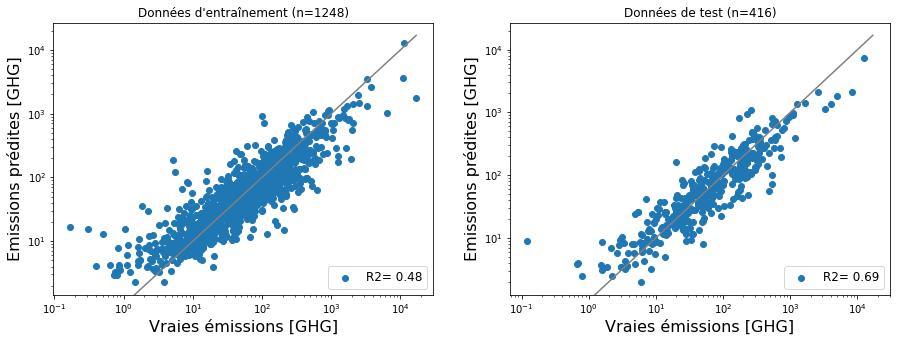

In [44]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vraies émissions [GHG]', fontsize=16)
    ax.set_ylabel(u'Emissions prédites [GHG]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

## Analyse des variables qui influent le plus sur la regression

In [45]:
coeff=pd.DataFrame(best_regressor.regressor_.coef_, features, columns=['Coefficients']).sort_values('Coefficients', ascending=False)

<AxesSubplot:xlabel='Coefficients', ylabel='1'>

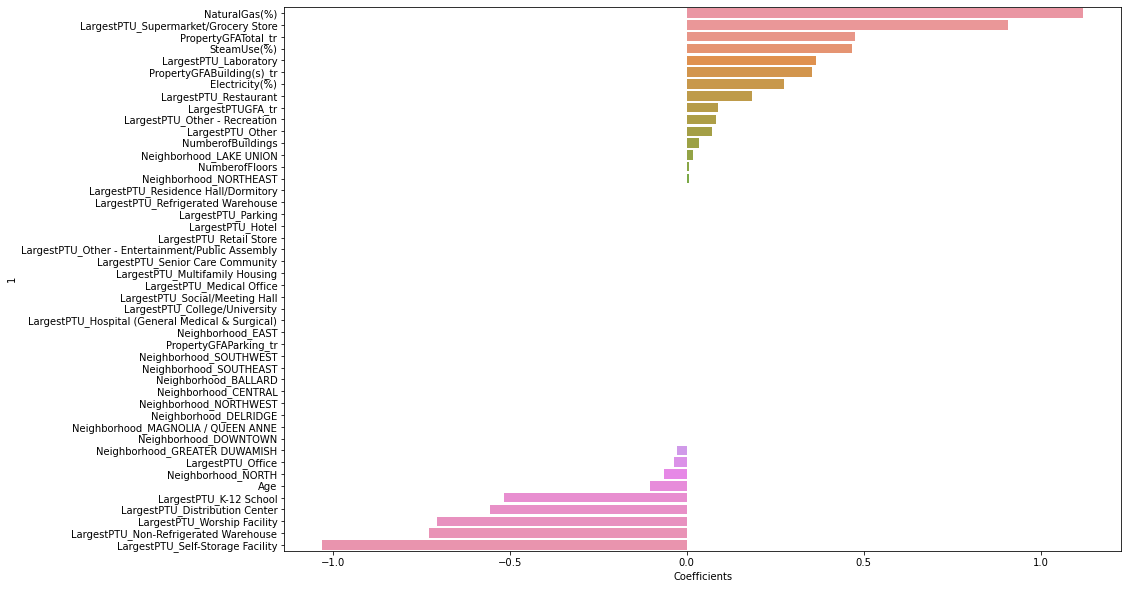

In [46]:
fig, ax1 =plt.subplots(figsize=(15,10))
sns.barplot(data=coeff, y=coeff.index,x='Coefficients')

[Retour au sommaire](#0)<br>

# VI. Régression ridge à noyau <a id="6"></a>


## **Définition du modèle**

On définit un modèle de régression KernelRidge, avec transformation de la cible `y` en log :

In [47]:
regressor = TransformedTargetRegressor(regressor=KernelRidge(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [48]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__coef0', 'regressor__degree', 'regressor__gamma', 'regressor__kernel', 'regressor__kernel_params', 'regressor', 'transformer'])

In [49]:
# set different regularisation strengths
alphas = np.logspace(-3, 0, 10)
gammas=np.logspace(-6, -3, 10)

param_grid = {
    'regressor__alpha': alphas,
    'regressor__degree':[2,3],
    'regressor__gamma' :gammas,
    'regressor__kernel':['rbf','polynomial']
}

In [50]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    param_grid=param_grid, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    cv=5, 
    verbose=True,
    refit='r2'
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Wall time: 2min 49s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=KernelRidge()),
             param_grid={'regressor__alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                         'regressor__degree': [2, 3],
                         'regressor__gamma': array([1.00000000e-06, 2.15443469e-06, 4.64158883e-06, 1.00000000e-05,
       2.15443469e-05, 4.64158883e-05, 1.00000000e-04, 2.15443469e-04,
       4.64158883e-04, 1.00000000e-03]),
                         'regressor__kernel': ['rbf', 'polynomial']},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
             verbose=True)

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [51]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,134,154,16,36,76,56,96,116,152,132,...,159,17,13,75,35,57,33,15,79,39
mean_fit_time,0.068734,0.052739,0.06561,0.062478,0.062583,0.074983,0.06243,0.075353,0.071857,0.056237,...,0.096879,0.056282,0.055934,0.08748,0.081246,0.050087,0.103101,0.053107,0.095995,0.112476
std_fit_time,0.012497,0.008092,0.006251,0.009891,0.010034,0.006249,0.000242,0.013648,0.012496,0.007654,...,0.006237,0.01252,0.012738,0.007653,0.006278,0.006202,0.018745,0.007659,0.014722,0.018219
mean_score_time,0.012496,0.018724,0.012496,0.012504,0.018748,0.015621,0.009373,0.012389,0.018747,0.015621,...,0.015623,0.006249,0.009528,0.024994,0.015621,0.012498,0.015621,0.006254,0.025998,0.021954
std_score_time,0.006248,0.00626,0.006248,0.006252,0.006248,0.00988,0.007653,0.00427,0.006252,0.000001,...,0.000003,0.007653,0.007785,0.007653,0.0,0.006249,0.000001,0.00766,0.011888,0.007759
param_regressor__alpha,0.01,0.01,0.001,0.001,0.002154,0.002154,0.004642,0.004642,0.01,0.01,...,0.01,0.001,0.001,0.002154,0.001,0.002154,0.001,0.001,0.002154,0.001
param_regressor__degree,2,3,2,3,3,2,2,3,3,2,...,3,2,2,3,3,2,3,2,3,3
param_regressor__gamma,0.000215,0.000215,0.000464,0.000464,0.000464,0.000464,0.000464,0.000464,0.0001,0.0001,...,0.001,0.000464,0.0001,0.000215,0.000215,0.000464,0.0001,0.000215,0.001,0.001
param_regressor__kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,polynomial,polynomial,polynomial,polynomial,polynomial,polynomial,polynomial,polynomial,polynomial,polynomial
params,"{'regressor__alpha': 0.01, 'regressor__degree'...","{'regressor__alpha': 0.01, 'regressor__degree'...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.0021544346900318843, 'r...","{'regressor__alpha': 0.0021544346900318843, 'r...","{'regressor__alpha': 0.004641588833612777, 're...","{'regressor__alpha': 0.004641588833612777, 're...","{'regressor__alpha': 0.01, 'regressor__degree'...","{'regressor__alpha': 0.01, 'regressor__degree'...",...,"{'regressor__alpha': 0.01, 'regressor__degree'...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.0021544346900318843, 'r...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.0021544346900318843, 'r...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.0021544346900318843, 'r...","{'regressor__alpha': 0.001, 'regressor__degree..."
split0_test_r2,0.398566,0.398566,0.557801,0.557801,0.533036,0.533036,0.492031,0.492031,0.36037,0.36037,...,0.527798,0.564627,0.502137,0.524159,0.555388,0.541428,0.523144,0.540014,0.569153,0.572351


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [52]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=KernelRidge(alpha=0.01, degree=2,
                                                 gamma=0.00021544346900318823,
                                                 kernel='rbf'))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [53]:
best_regressor.regressor_.get_params()

{'alpha': 0.01,
 'coef0': 1,
 'degree': 2,
 'gamma': 0.00021544346900318823,
 'kernel': 'rbf',
 'kernel_params': None}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [54]:
grid_search.best_score_

0.5794793646927702

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [55]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [56]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/émission moyenne: %.2f" % (np.sqrt(error_train)/emmissions_moy_train))
print("MAE entrainement/émission moyenne:: %.2f" % (mae_train/emmissions_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/émission moyenne:: %.2f" % (np.sqrt( error_test)/emmissions_moy_test))
print("MAE test/émission moyenne:: %.2f" % (mae_test/emmissions_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/émission moyenne: 2.92
MAE entrainement/émission moyenne:: 0.48
Coefficient de determination entrainement: 0.50 

RMSE test/émission moyenne:: 1.83
MAE test/émission moyenne:: 0.44
Coefficient de determination test: 0.78


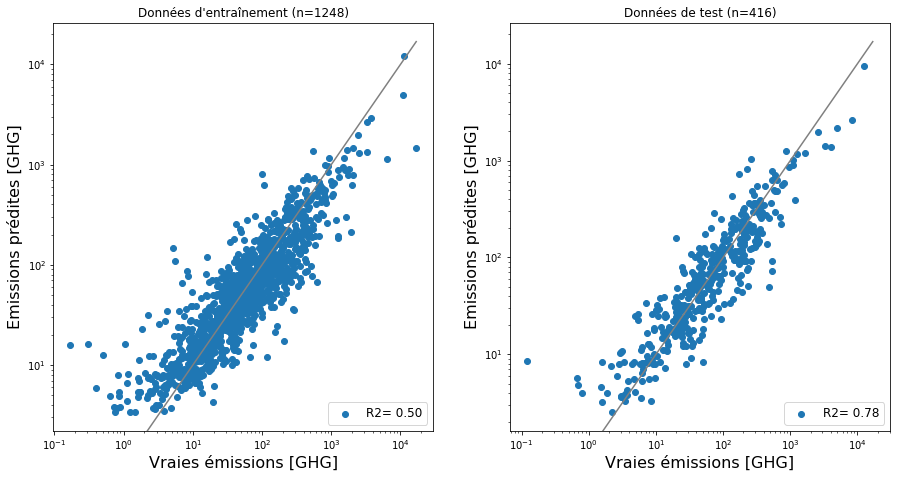

In [57]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 7.5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vraies émissions [GHG]', fontsize=16)
    ax.set_ylabel(u'Emissions prédites [GHG]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

[Retour au sommaire](#0)<br>

## VII. Arbre de décision <a id="7"></a>

In [58]:
dtree=DecisionTreeRegressor()

In [59]:
#paramètres pour la recherche
param_grid = {
    "max_depth": [4,5,6,7],
    "min_samples_split":[2,5,10,15,20],
    "min_samples_leaf":[5,10,15,20],
    }

In [60]:
%%time

grid_search = GridSearchCV(
    estimator=dtree, 
    param_grid=param_grid, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    cv=5, 
    verbose=True,
     refit='r2'
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Wall time: 1.73 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 15, 20]},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
             verbose=True)

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [61]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,77,79,76,75,78,59,57,55,58,56,...,7,6,24,23,64,44,3,4,63,43
mean_fit_time,0.006254,0.006248,0.003124,0.006248,0.003119,0.003124,0.006248,0.003123,0.0,0.006249,...,0.003128,0.003124,0.006249,0.003124,0.003125,0.003125,0.001598,0.003134,0.006254,0.003124
std_fit_time,0.00766,0.007653,0.006249,0.007653,0.006238,0.006248,0.007653,0.006246,0.0,0.007653,...,0.006255,0.006249,0.007653,0.006248,0.006249,0.006251,0.003197,0.006269,0.00766,0.006249
mean_score_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003124,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0016,0.0,0.0,0.003125
std_score_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006249,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.003201,0.0,0.0,0.006249
param_max_depth,7,7,7,7,7,6,6,6,6,6,...,4,4,5,5,7,6,4,4,7,6
param_min_samples_leaf,20,20,20,20,20,20,20,20,20,20,...,10,10,5,5,5,5,5,5,5,5
param_min_samples_split,10,20,5,2,15,20,10,2,15,5,...,10,5,20,15,20,20,15,20,15,15
params,"{'max_depth': 7, 'min_samples_leaf': 20, 'min_...","{'max_depth': 7, 'min_samples_leaf': 20, 'min_...","{'max_depth': 7, 'min_samples_leaf': 20, 'min_...","{'max_depth': 7, 'min_samples_leaf': 20, 'min_...","{'max_depth': 7, 'min_samples_leaf': 20, 'min_...","{'max_depth': 6, 'min_samples_leaf': 20, 'min_...","{'max_depth': 6, 'min_samples_leaf': 20, 'min_...","{'max_depth': 6, 'min_samples_leaf': 20, 'min_...","{'max_depth': 6, 'min_samples_leaf': 20, 'min_...","{'max_depth': 6, 'min_samples_leaf': 20, 'min_...",...,"{'max_depth': 4, 'min_samples_leaf': 10, 'min_...","{'max_depth': 4, 'min_samples_leaf': 10, 'min_...","{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 7, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 6, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 4, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 4, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 7, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 6, 'min_samples_leaf': 5, 'min_s..."
split0_test_r2,0.19699,0.19699,0.19699,0.19699,0.19699,0.198526,0.198526,0.198526,0.198526,0.198526,...,0.389491,0.389491,0.438081,0.438081,0.450106,0.444357,0.423005,0.423005,0.464605,0.444357
split1_test_r2,0.213798,0.213798,0.213798,0.213798,0.213798,0.21378,0.21378,0.21378,0.21378,0.21378,...,0.138863,0.138863,-0.021419,-0.021419,0.004136,0.003203,0.008175,0.008175,-0.000879,0.002441


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [62]:
best_regressor = grid_search.best_estimator_
best_regressor

DecisionTreeRegressor(max_depth=7, min_samples_leaf=20, min_samples_split=10)

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [63]:
best_regressor.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 20,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [64]:
grid_search.best_score_

0.2664487917785139

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [65]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [66]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/émission moyenne: %.2f" % (np.sqrt(error_train)/emmissions_moy_train))
print("MAE entrainement/émission moyenne:: %.2f" % (mae_train/emmissions_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/émission moyenne:: %.2f" % (np.sqrt( error_test)/emmissions_moy_test))
print("MAE test/émission moyenne:: %.2f" % (mae_test/emmissions_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/émission moyenne: 3.42
MAE entrainement/émission moyenne:: 0.73
Coefficient de determination entrainement: 0.32 

RMSE test/émission moyenne:: 3.36
MAE test/émission moyenne:: 0.90
Coefficient de determination test: 0.25


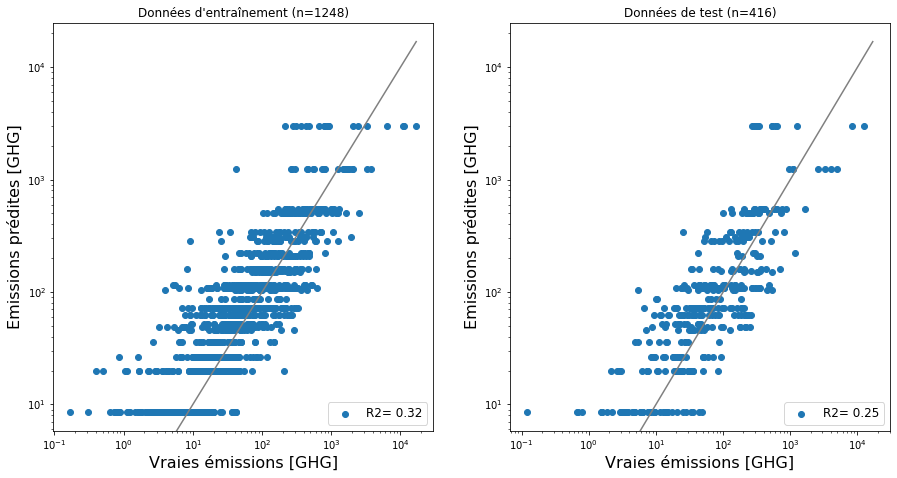

In [67]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 7.5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vraies émissions [GHG]', fontsize=16)
    ax.set_ylabel(u'Emissions prédites [GHG]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

[Retour au sommaire](#0)<br>

# VIII. Gradient boosting regression <a id="8"></a>

## **Définition du modèle**

On définit un modèle de régression qui est un GradientBoostingRegressor(), avec transformation de la cible `y` en log :

In [68]:
regressor = TransformedTargetRegressor(regressor=GradientBoostingRegressor(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [69]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__init', 'regressor__learning_rate', 'regressor__loss', 'regressor__max_depth', 'regressor__max_features', 'regressor__max_leaf_nodes', 'regressor__min_impurity_decrease', 'regressor__min_samples_leaf', 'regressor__min_samples_split', 'regressor__min_weight_fraction_leaf', 'regressor__n_estimators', 'regressor__n_iter_no_change', 'regressor__random_state', 'regressor__subsample', 'regressor__tol', 'regressor__validation_fraction', 'regressor__verbose', 'regressor__warm_start', 'regressor', 'transformer'])

In [70]:
# set different regularisation strengths
learning_rates = np.logspace(-3, 0, 10)

#paramètres pour la recherche
param_grid = {
    "regressor__n_estimators": [100,500],
    "regressor__max_depth": [3,4,5],
    "regressor__learning_rate": learning_rates,
}

In [71]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    param_grid=param_grid, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    cv=5, 
    verbose=True,
    refit='r2'
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Wall time: 7min 52s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=GradientBoostingRegressor()),
             param_grid={'regressor__learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                         'regressor__max_depth': [3, 4, 5],
                         'regressor__n_estimators': [100, 500]},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
             verbose=True)

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [74]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,38,27,25,44,34,35,21,23,29,32,...,0,37,58,56,51,52,50,59,55,54
mean_fit_time,0.206261,1.03121,0.881848,0.252158,0.284384,1.381967,1.224752,1.403147,1.372063,0.218737,...,0.177707,0.795491,0.312988,0.206196,1.123914,0.263333,0.268558,1.094326,0.804162,0.190819
std_fit_time,0.00622,0.009918,0.081955,0.013379,0.006195,0.107003,0.115944,0.006187,0.088548,0.004879,...,0.011987,0.054271,0.027361,0.006251,0.114901,0.010122,0.029836,0.070667,0.016714,0.028291
mean_score_time,0.0,0.009367,0.0,0.0,0.003124,0.009084,0.007852,0.006248,0.007914,0.0,...,0.0,0.003124,0.0,0.003124,0.006248,0.0,0.0,0.006249,0.004722,0.00321
std_score_time,0.0,0.007648,0.0,0.0,0.006248,0.007436,0.006986,0.007652,0.010043,0.0,...,0.0,0.006249,0.0,0.006249,0.007652,0.0,0.0,0.007653,0.006267,0.003931
param_regressor__learning_rate,0.1,0.021544,0.021544,0.215443,0.046416,0.046416,0.01,0.01,0.021544,0.046416,...,0.001,0.1,1.0,1.0,0.464159,0.464159,0.464159,1.0,1.0,1.0
param_regressor__max_depth,4,4,3,4,5,5,4,5,5,4,...,3,3,5,4,4,5,4,5,3,3
param_regressor__n_estimators,100,500,500,100,100,500,500,500,500,100,...,100,500,100,100,500,100,100,500,500,100
params,"{'regressor__learning_rate': 0.1, 'regressor__...",{'regressor__learning_rate': 0.021544346900318...,{'regressor__learning_rate': 0.021544346900318...,{'regressor__learning_rate': 0.215443469003188...,{'regressor__learning_rate': 0.046415888336127...,{'regressor__learning_rate': 0.046415888336127...,"{'regressor__learning_rate': 0.01, 'regressor_...","{'regressor__learning_rate': 0.01, 'regressor_...",{'regressor__learning_rate': 0.021544346900318...,{'regressor__learning_rate': 0.046415888336127...,...,"{'regressor__learning_rate': 0.001, 'regressor...","{'regressor__learning_rate': 0.1, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...",{'regressor__learning_rate': 0.464158883361277...,{'regressor__learning_rate': 0.464158883361277...,{'regressor__learning_rate': 0.464158883361277...,"{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__..."
split0_test_r2,0.69049,0.606543,0.532408,0.645892,0.6203,0.731822,0.483345,0.604188,0.653361,0.495225,...,-0.054589,0.808722,0.723079,0.500613,0.712169,0.803246,0.774672,0.082309,0.008385,-2.46516
split1_test_r2,0.114555,0.091376,0.148894,0.087363,0.085196,0.097457,0.106841,0.090721,0.102441,0.11059,...,-0.019658,0.093276,-0.595447,0.107666,0.124962,0.11455,0.107327,-2.403934,0.305196,0.345215


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [75]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GradientBoostingRegressor(max_depth=4))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [76]:
best_regressor.regressor_.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [77]:
grid_search.best_score_

0.5039420300491915

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [78]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [79]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/émission moyenne: %.2f" % (np.sqrt(error_train)/emmissions_moy_train))
print("MAE entrainement/émission moyenne:: %.2f" % (mae_train/emmissions_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/émission moyenne:: %.2f" % (np.sqrt( error_test)/emmissions_moy_test))
print("MAE test/émission moyenne:: %.2f" % (mae_test/emmissions_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/émission moyenne: 1.25
MAE entrainement/émission moyenne:: 0.27
Coefficient de determination entrainement: 0.91 

RMSE test/émission moyenne:: 1.02
MAE test/émission moyenne:: 0.33
Coefficient de determination test: 0.93


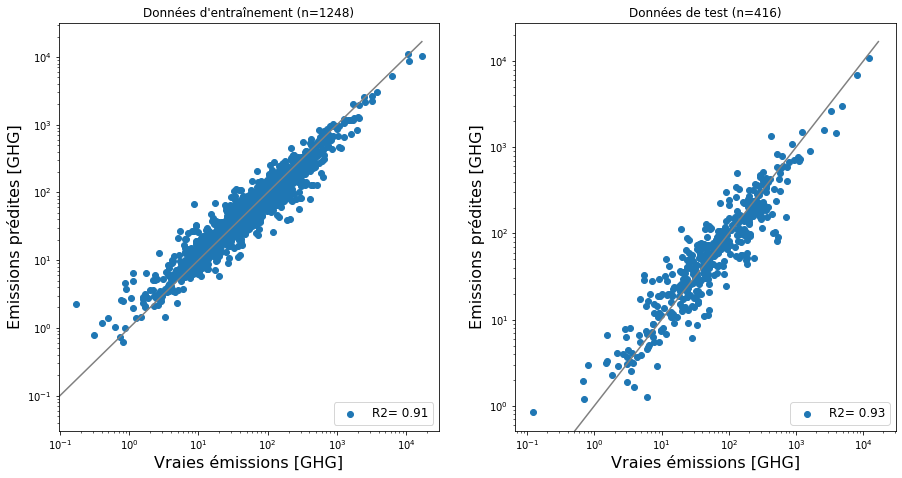

In [80]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 7.5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vraies émissions [GHG]', fontsize=16)
    ax.set_ylabel(u'Emissions prédites [GHG]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

## Analyse des variables qui influent le plus sur la regression

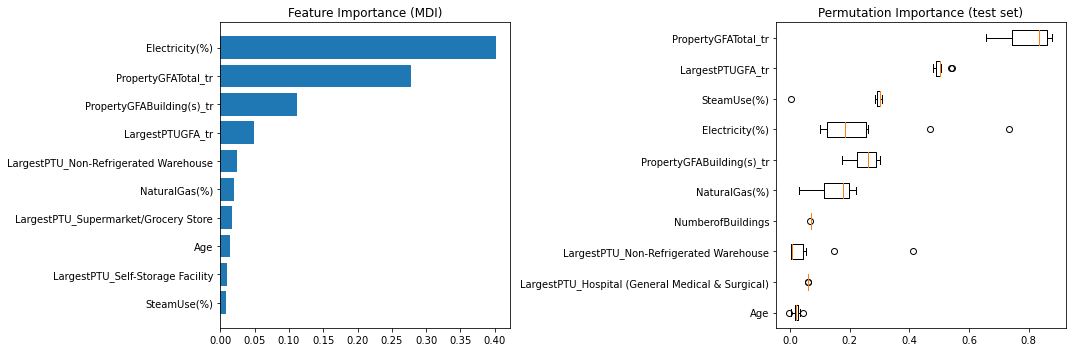

In [81]:
fig = plt.figure(figsize=(15, 5))

# Compute and plot feature importance 1
plt.subplot(1, 2, 1)
feature_importance = best_regressor.regressor_.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title("Feature Importance (MDI)") #MDI=mean decrease in impurity

# Compute and plot feature importance 2
plt.subplot(1, 2, 2)
result = permutation_importance(best_regressor, X_CO2_test_tr.toarray(), y_CO2_test, n_repeats=10)
sorted_idx = result.importances_mean.argsort()[-10:]
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(features)[sorted_idx])
plt.title("Permutation Importance (test set)")

fig.tight_layout()

[Retour au sommaire](#0)<br>

# IX. Evaluation intérêt énergie star <a id="9"></a>

Dans cette section nous allons intégrer la variable EnergyStarScore et évaluer si elle permet d'améliorer notre meilleur modèle.

## A. Modèle avec Energy Star

### Préparation des données

crééons un dataframe avec toutes les valeurs non-nulles de sur la variable énergie Star

In [82]:
benchmark_star=benchmark_NR.loc[benchmark_NR['ENERGYSTARScore'].notnull()]

In [83]:
benchmark_star.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092 entries, 0 to 1659
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   OSEBuildingID                       1092 non-null   int64  
 1   DataYear                            1092 non-null   int64  
 2   BuildingType                        1092 non-null   object 
 3   PrimaryPropertyType                 1092 non-null   object 
 4   PropertyName                        1092 non-null   object 
 5   Address                             1092 non-null   object 
 6   City                                1092 non-null   object 
 7   State                               1092 non-null   object 
 8   ZipCode                             1089 non-null   float64
 9   TaxParcelIdentificationNumber       1092 non-null   object 
 10  CouncilDistrictCode                 1092 non-null   int64  
 11  Neighborhood                        1092 no

In [84]:
#sélection des colonnes
col_x=['Neighborhood',
    'NumberofBuildings',
    'NumberofFloors', 
    'LargestPropertyUseType', 
    'SteamUse(%)', 
    'Electricity(%)', 
    'NaturalGas(%)', 
    'Age',
    'PropertyGFATotal_tr', 
    'PropertyGFABuilding(s)_tr', 
    'PropertyGFAParking_tr', 
    'LargestPropertyUseTypeGFA_tr',
    'ENERGYSTARScore' 
      ]
X_CO2=benchmark_star.loc[:,col_x]
y_CO2=benchmark_star.loc[:,'TotalGHGEmissions']

**train_test split**

In [85]:
X_CO2_train,X_CO2_test,y_CO2_train,y_CO2_test=train_test_split(X_CO2,y_CO2, test_size=0.25, random_state=2022)
X_CO2_train.shape

(819, 13)

**Normalisation des variables numériques & encodage des variables catégorielles**

Nous allons utiliser OneHotEncoder pour transformer les variables catégorielles en dummy variable et procéder au centrage et à la réduction des données numériques

In [86]:
ct = make_column_transformer(
    (preprocessing.StandardScaler(),
     make_column_selector(dtype_include=np.number)),  # colonnes numériques
    (OneHotEncoder(handle_unknown='ignore'),
     make_column_selector(dtype_include=object)))  # colonnes catégorie

X_CO2_train_tr=ct.fit_transform(X_CO2_train) 
X_CO2_test_tr=ct.transform(X_CO2_test)

Afin d'améliorer la lisibilité récupérons les noms des features et simplifions les noms

In [87]:
# récupérons les noms des features
features=pd.Series(ct.get_feature_names_out()).str.replace('PropertyUseType', 'PTU').str.split('__', expand=True).loc[:,1]

## **Définition du modèle**

On définit un modèle de régression qui est un GradientBoostingRegressor(), avec transformation de la cible `y` en log :

In [88]:
regressor = TransformedTargetRegressor(regressor=GradientBoostingRegressor(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [89]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__init', 'regressor__learning_rate', 'regressor__loss', 'regressor__max_depth', 'regressor__max_features', 'regressor__max_leaf_nodes', 'regressor__min_impurity_decrease', 'regressor__min_samples_leaf', 'regressor__min_samples_split', 'regressor__min_weight_fraction_leaf', 'regressor__n_estimators', 'regressor__n_iter_no_change', 'regressor__random_state', 'regressor__subsample', 'regressor__tol', 'regressor__validation_fraction', 'regressor__verbose', 'regressor__warm_start', 'regressor', 'transformer'])

In [90]:
# set different regularisation strengths
learning_rates = np.logspace(-3, 0, 10)

#paramètres pour la recherche
param_grid = {
    "regressor__n_estimators": [100,500],
    "regressor__max_depth": [3,4,5],
    "regressor__learning_rate": learning_rates,
}

In [91]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    param_grid=param_grid, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    cv=5, 
    verbose=True,
    refit='r2'
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Wall time: 2min 19s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=GradientBoostingRegressor()),
             param_grid={'regressor__learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                         'regressor__max_depth': [3, 4, 5],
                         'regressor__n_estimators': [100, 500]},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
             verbose=True)

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [92]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,25,31,47,40,27,36,35,43,42,23,...,6,4,2,0,51,50,48,49,57,56
mean_fit_time,0.55615,0.60941,0.920205,0.171833,0.791093,0.126156,0.976967,0.571282,0.112473,0.8539,...,0.112471,0.16884,0.146536,0.161584,0.703089,0.140641,0.13441,0.553035,0.618798,0.146861
std_fit_time,0.007678,0.062998,0.078141,0.000003,0.066506,0.014942,0.148618,0.028586,0.006249,0.00856,...,0.006253,0.006132,0.011874,0.003222,0.000286,0.000079,0.012456,0.007677,0.015995,0.007679
mean_score_time,0.0,0.0,0.00515,0.0,0.006248,0.004725,0.0,0.003124,0.0,0.0,...,0.0,0.003127,0.0,0.003205,0.0,0.0,0.0,0.003124,0.0,0.003124
std_score_time,0.0,0.0,0.006542,0.0,0.007652,0.006268,0.0,0.006248,0.0,0.0,...,0.0,0.006253,0.0,0.003925,0.0,0.0,0.0,0.006249,0.0,0.006249
param_regressor__learning_rate,0.021544,0.046416,0.215443,0.1,0.021544,0.1,0.046416,0.215443,0.215443,0.01,...,0.002154,0.001,0.001,0.001,0.464159,0.464159,0.464159,0.464159,1.0,1.0
param_regressor__max_depth,3,3,5,5,4,3,5,3,3,5,...,3,5,4,3,4,4,3,3,4,4
param_regressor__n_estimators,500,500,500,100,500,100,500,500,100,500,...,100,100,100,100,500,100,100,500,500,100
params,{'regressor__learning_rate': 0.021544346900318...,{'regressor__learning_rate': 0.046415888336127...,{'regressor__learning_rate': 0.215443469003188...,"{'regressor__learning_rate': 0.1, 'regressor__...",{'regressor__learning_rate': 0.021544346900318...,"{'regressor__learning_rate': 0.1, 'regressor__...",{'regressor__learning_rate': 0.046415888336127...,{'regressor__learning_rate': 0.215443469003188...,{'regressor__learning_rate': 0.215443469003188...,"{'regressor__learning_rate': 0.01, 'regressor_...",...,{'regressor__learning_rate': 0.002154434690031...,"{'regressor__learning_rate': 0.001, 'regressor...","{'regressor__learning_rate': 0.001, 'regressor...","{'regressor__learning_rate': 0.001, 'regressor...",{'regressor__learning_rate': 0.464158883361277...,{'regressor__learning_rate': 0.464158883361277...,{'regressor__learning_rate': 0.464158883361277...,{'regressor__learning_rate': 0.464158883361277...,"{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__..."
split0_test_r2,0.758473,0.729272,0.622891,0.662269,0.67678,0.693503,0.664729,0.869248,0.829218,0.643435,...,-0.022282,-0.029401,-0.029354,-0.030431,0.475657,0.489393,0.437922,0.494871,-6.053663,-5.689688
split1_test_r2,0.287865,0.227291,0.381454,0.198383,0.268011,0.255971,0.205417,0.253435,0.250925,0.191165,...,-0.005357,-0.009058,-0.00959,-0.009378,0.349597,0.357559,0.123759,0.132522,0.164722,0.162073


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [93]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GradientBoostingRegressor(learning_rate=0.021544346900318832,
                                                               n_estimators=500))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [94]:
best_regressor.regressor_.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.021544346900318832,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [95]:
grid_search.best_score_

0.6213752985321908

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [96]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [97]:
emmissions_moy_train=np.mean(y_CO2_train)
emmissions_moy_test=np.mean(y_CO2_test)

In [98]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/émission moyenne: %.2f" % (np.sqrt(error_train)/emmissions_moy_train))
print("MAE entrainement/émission moyenne:: %.2f" % (mae_train/emmissions_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/émission moyenne:: %.2f" % (np.sqrt( error_test)/emmissions_moy_test))
print("MAE test/émission moyenne:: %.2f" % (mae_test/emmissions_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/émission moyenne: 0.91
MAE entrainement/émission moyenne:: 0.17
Coefficient de determination entrainement: 0.96 

RMSE test/émission moyenne:: 1.63
MAE test/émission moyenne:: 0.38
Coefficient de determination test: 0.71


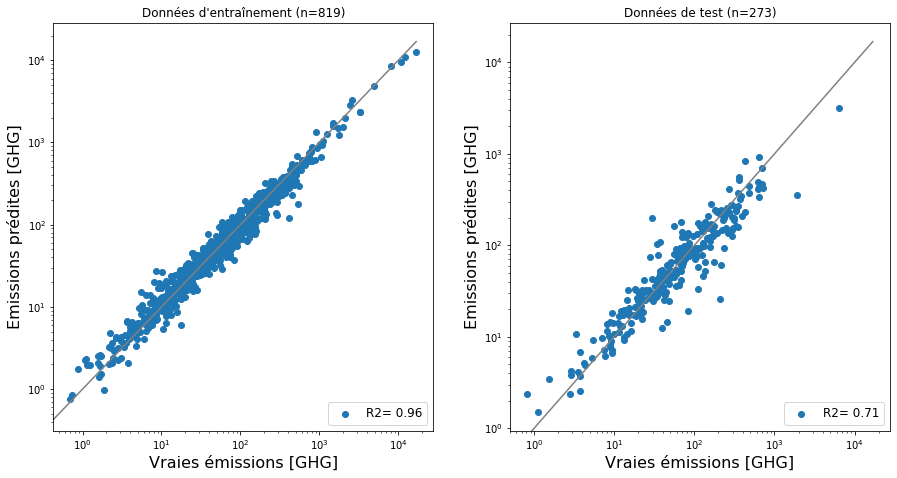

In [99]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 7.5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vraies émissions [GHG]', fontsize=16)
    ax.set_ylabel(u'Emissions prédites [GHG]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

## B. Modèle sans Energie Star  - Bases comparables

**Suppression de la colonne ENERGYSTARSScore**

In [100]:
X_CO2_train.drop(columns='ENERGYSTARScore', inplace=True)
X_CO2_test.drop(columns='ENERGYSTARScore', inplace=True)

**Normalisation des variables numériques & encodage des variables catégorielles**

Nous allons utiliser OneHotEncoder pour transformer les variables catégorielles en dummy variable et procéder au centrage et à la réduction des données numériques

In [101]:
ct = make_column_transformer(
    (preprocessing.StandardScaler(),
     make_column_selector(dtype_include=np.number)),  # colonnes numériques
    (OneHotEncoder(handle_unknown='ignore'),
     make_column_selector(dtype_include=object)))  # colonnes catégorie

X_CO2_train_tr=ct.fit_transform(X_CO2_train) 
X_CO2_test_tr=ct.transform(X_CO2_test)

Afin d'améliorer la lisibilité récupérons les noms des features et simplifions les noms

In [102]:
# récupérons les noms des features
features=pd.Series(ct.get_feature_names_out()).str.replace('PropertyUseType', 'PTU').str.split('__', expand=True).loc[:,1]

## **Définition du modèle**

On définit un modèle de régression qui est un GradientBoostingRegressor(), avec transformation de la cible `y` en log :

In [103]:
regressor = TransformedTargetRegressor(regressor=GradientBoostingRegressor(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [104]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__init', 'regressor__learning_rate', 'regressor__loss', 'regressor__max_depth', 'regressor__max_features', 'regressor__max_leaf_nodes', 'regressor__min_impurity_decrease', 'regressor__min_samples_leaf', 'regressor__min_samples_split', 'regressor__min_weight_fraction_leaf', 'regressor__n_estimators', 'regressor__n_iter_no_change', 'regressor__random_state', 'regressor__subsample', 'regressor__tol', 'regressor__validation_fraction', 'regressor__verbose', 'regressor__warm_start', 'regressor', 'transformer'])

In [105]:
# set different regularisation strengths
learning_rates = np.logspace(-3, 0, 10)

#paramètres pour la recherche
param_grid = {
    "regressor__n_estimators": [100,500],
    "regressor__max_depth": [3,4,5],
    "regressor__learning_rate": learning_rates,
}

In [106]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    param_grid=param_grid, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    cv=5, 
    verbose=True,
    refit='r2'
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Wall time: 2min 18s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=GradientBoostingRegressor()),
             param_grid={'regressor__learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                         'regressor__max_depth': [3, 4, 5],
                         'regressor__n_estimators': [100, 500]},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
             verbose=True)

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [107]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,35,53,41,46,52,29,40,34,25,36,...,2,0,48,58,49,57,56,54,55,59
mean_fit_time,1.049925,0.898211,0.844253,0.167176,0.163488,0.927481,0.166123,0.189661,0.704179,0.109386,...,0.189101,0.106422,0.100631,0.206398,0.553425,0.64753,0.131303,0.099976,0.518684,0.461274
std_fit_time,0.050393,0.091543,0.068045,0.007869,0.008355,0.065002,0.006937,0.03127,0.047234,0.009914,...,0.01479,0.011486,0.007295,0.018005,0.062193,0.074047,0.007585,0.007667,0.006222,0.015771
mean_score_time,0.0016,0.003336,0.0,0.0,0.0,0.0,0.0,0.001607,0.0,0.003124,...,0.0016,0.006254,0.003124,0.0,0.000208,0.0,0.0,0.003123,0.0,0.0
std_score_time,0.0032,0.004091,0.0,0.0,0.0,0.0,0.0,0.003213,0.0,0.006249,...,0.0032,0.00766,0.006248,0.0,0.000417,0.0,0.0,0.006246,0.0,0.0
param_regressor__learning_rate,0.046416,0.464159,0.1,0.215443,0.464159,0.021544,0.1,0.046416,0.021544,0.1,...,0.001,0.001,0.464159,1.0,0.464159,1.0,1.0,1.0,1.0,1.0
param_regressor__max_depth,5,5,5,5,5,5,5,5,3,3,...,4,3,3,5,3,4,4,3,3,5
param_regressor__n_estimators,500,500,500,100,100,500,100,100,500,100,...,100,100,100,100,500,500,100,100,500,500
params,{'regressor__learning_rate': 0.046415888336127...,{'regressor__learning_rate': 0.464158883361277...,"{'regressor__learning_rate': 0.1, 'regressor__...",{'regressor__learning_rate': 0.215443469003188...,{'regressor__learning_rate': 0.464158883361277...,{'regressor__learning_rate': 0.021544346900318...,"{'regressor__learning_rate': 0.1, 'regressor__...",{'regressor__learning_rate': 0.046415888336127...,{'regressor__learning_rate': 0.021544346900318...,"{'regressor__learning_rate': 0.1, 'regressor__...",...,"{'regressor__learning_rate': 0.001, 'regressor...","{'regressor__learning_rate': 0.001, 'regressor...",{'regressor__learning_rate': 0.464158883361277...,"{'regressor__learning_rate': 1.0, 'regressor__...",{'regressor__learning_rate': 0.464158883361277...,"{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__..."
split0_test_r2,0.573809,0.450217,0.571449,0.560165,0.460049,0.523707,0.561893,0.511122,0.736035,0.802592,...,-0.029359,-0.030446,0.390929,-0.495064,0.470557,-4.03428,-5.319617,0.087512,-0.861128,-3.248589
split1_test_r2,0.194863,0.152831,0.187205,0.13893,0.20203,0.192619,0.170453,0.178693,0.184045,0.199857,...,-0.00965,-0.009935,0.138149,0.141551,0.161065,0.238676,0.238111,0.021694,0.038245,0.129298


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [108]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GradientBoostingRegressor(learning_rate=0.046415888336127774,
                                                               max_depth=5,
                                                               n_estimators=500))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [109]:
best_regressor.regressor_.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.046415888336127774,
 'loss': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [110]:
grid_search.best_score_

0.5961968572951231

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [111]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [112]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/émission moyenne: %.2f" % (np.sqrt(error_train)/emmissions_moy_train))
print("MAE entrainement/émission moyenne:: %.2f" % (mae_train/emmissions_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/émission moyenne:: %.2f" % (np.sqrt( error_test)/emmissions_moy_test))
print("MAE test/émission moyenne:: %.2f" % (mae_test/emmissions_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/émission moyenne: 0.21
MAE entrainement/émission moyenne:: 0.05
Coefficient de determination entrainement: 1.00 

RMSE test/émission moyenne:: 1.04
MAE test/émission moyenne:: 0.33
Coefficient de determination test: 0.88


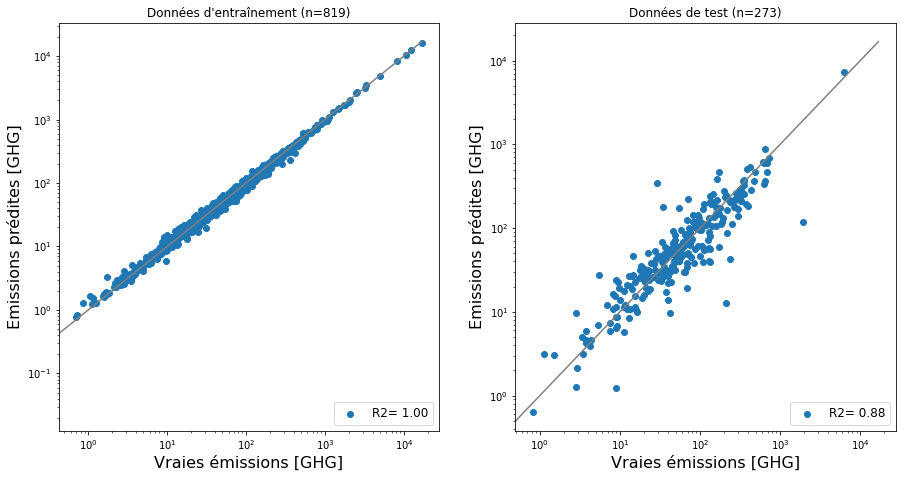

In [113]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 7.5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vraies émissions [GHG]', fontsize=16)
    ax.set_ylabel(u'Emissions prédites [GHG]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')